In [9]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from tqdm.auto import tqdm

In [10]:
def scale_to_z(a, min_depth, max_depth, z_scale, dtype=np.uint8):
    """ Scales an array of values from specified min, max range to 0-z_scale
        Optionally specify the data type of the output (default is uint16)
    """
    bg_mask = np.full(a.shape, 255)
    img = (((a - min_depth) / float(max_depth - min_depth)) * 254)
    depth_img = np.where(a == np.inf, bg_mask, img)
    # print(np.sum(a == z_bg))
    
    return depth_img.astype(dtype)

def scale_to_z_v2(a, max_z_distance, dtype=np.uint8):
    """ Scales an array of values from specified min, max range to 0-z_scale
        Optionally specify the data type of the output (default is uint16)
    """
    bg_mask = np.full(a.shape, 255)
    img = (((a - 0) / float(max_z_distance - 0)) * 254)
    depth_img = np.where(a == np.inf, bg_mask, img)
    # print(np.sum(a == z_bg))
    return depth_img.astype(dtype)

def get_spatial_limit_of_point_cloud(pc_mesh):
    np_vertices = np.asarray(pc_mesh.vertices)
    x_max = np.max(np_vertices[:, 0])
    x_min = np.min(np_vertices[:, 0])
    y_max = np.max(np_vertices[:, 1])
    y_min = np.min(np_vertices[:, 1])
    z_min = np.min(np_vertices[:, 2])
    z_max = np.max(np_vertices[:, 2])
    spatial_limit = {'x_max': x_max, 'x_min': x_min, 'y_max': y_max, 'y_min': y_min, 'z_min': z_min, 'z_max': z_max}
    return spatial_limit

# create depthmap with ray tracing, z-min and z-max will be changed in every single characters 
def ray_tracing_depth_map(pc_mesh, 
                          side_range=(-9, 9), 
                          fwd_range=(-9, 9), 
                          res=(16000, 16000, 255),
                          z_camera=4):
    """Creates an depth map image with ray tracing (ray casting) technique.
    Args:
        pc_mesh: mesh of sino-nom character
        side_range: (tuple of two floats)
                    (-left, right) in metres
                    left and right limits of rectangle to look at.
        fwd_range:  (tuple of two floats)
                    (-behind, front) in metres
                    back and front limits of rectangle to look at.
        res:        (int, int, float) desired resolution in metres to use
    Returns:
        depth_map img
    """
    # Create a scene and add the triangle mesh
    t_pc_mesh = o3d.t.geometry.TriangleMesh.from_legacy(pc_mesh)
    scene = o3d.t.geometry.RaycastingScene()
    character_id = scene.add_triangles(t_pc_mesh)
    side_width = side_range[1] - side_range[0]
    fwd_height = fwd_range[1] - fwd_range[0]
    ratio_width = side_width / res[0]
    ratio_height = fwd_height / res[1]
    x_range = side_range[0] + np.arange(res[0])*ratio_width
    y_range = fwd_range[0] + np.arange(res[1])*ratio_height
    x_mesh, y_mesh = np.meshgrid(x_range, y_range)
    x_mesh_flat = x_mesh.reshape((-1, ))
    y_mesh_flat = y_mesh.reshape((-1, ))
    z_mesh_flat = np.full((x_mesh_flat.shape[0], ), z_camera)
    direction = np.repeat(np.asarray([0, 0, -1]).reshape((1, -1)), z_mesh_flat.shape[0], axis=0)
    point_mesh = np.stack((x_mesh_flat, y_mesh_flat, z_mesh_flat), axis=1)
    rays = np.concatenate((point_mesh, direction), axis=1)
    rays = o3d.core.Tensor(rays, dtype=o3d.core.Dtype.Float32)
    ans = scene.cast_rays(rays)
    pixel_values = ans['t_hit'].numpy()
    pixel_values = pixel_values.reshape((res[0], res[1]))
    _, z_max_depth = -np.sort(-np.unique(pixel_values))[:2]
    z_min_depth = np.min(pixel_values)
    
    normalized_pixel_values = scale_to_z(pixel_values, z_min_depth, z_max_depth, res[2])
    img_inverted_matrix = np.array([[ratio_width, 0, 0, side_range[0]], [0, ratio_height, 0, fwd_range[0]], [0, 0, -(z_max_depth - z_min_depth)/res[2],z_camera - z_min_depth], [0, 0, 0, 1]])
    return img_inverted_matrix, normalized_pixel_values


def ray_tracing_depth_map_v2(pc_mesh, side_range=(-12, 12), fwd_range=(-12, 12), res=(2000, 2000, 255), z_max_camera=10, max_z_distance=16):
    t_pc_mesh = o3d.t.geometry.TriangleMesh.from_legacy(pc_mesh)
    scene = o3d.t.geometry.RaycastingScene()
    character_id = scene.add_triangles(t_pc_mesh)
    side_width = side_range[1] - side_range[0]
    fwd_height = fwd_range[1] - fwd_range[0]
    ratio_width = side_width / res[0]
    ratio_height = fwd_height / res[1]
    x_range = side_range[0] + np.arange(res[0])*ratio_width
    y_range = fwd_range[0] + np.arange(res[1])*ratio_height
    x_mesh, y_mesh = np.meshgrid(x_range, y_range)
    x_mesh_flat = x_mesh.reshape((-1, ))
    y_mesh_flat = y_mesh.reshape((-1, ))
    z_mesh_flat = np.full((x_mesh_flat.shape[0], ), z_max_camera)
    direction = np.repeat(np.asarray([0, 0, -1]).reshape((1, -1)), z_mesh_flat.shape[0], axis=0)
    point_mesh = np.stack((x_mesh_flat, y_mesh_flat, z_mesh_flat), axis=1)
    rays = np.concatenate((point_mesh, direction), axis=1)
    rays = o3d.core.Tensor(rays, dtype=o3d.core.Dtype.Float32)
    ans = scene.cast_rays(rays)
    pixel_values = ans['t_hit'].numpy()
    pixel_values = pixel_values.reshape((res[0], res[1]))
    _, z_max_depth = -np.sort(-np.unique(pixel_values))[:2]

    normalized_pixel_values = scale_to_z_v2(pixel_values, max_z_distance)
    img_inverted_matrix = np.array([[ratio_width, 0, 0, side_range[0]], [0, ratio_height, 0, fwd_range[0]], [0, 0, -max_z_distance/254.0, z_max_camera], [0, 0, 0, 1]])
    return img_inverted_matrix, normalized_pixel_values

def convert_pc_to_depth_map_v2(stl_path):
    pc_mesh = o3d.io.read_triangle_mesh(stl_path)
    spatial_limit = get_spatial_limit_of_point_cloud(pc_mesh)
    y_length = spatial_limit["y_max"] - spatial_limit["y_min"]
    x_length = spatial_limit["x_max"] - spatial_limit["x_min"]
    print(spatial_limit)
    if y_length > x_length:
        x_need = (y_length - x_length) / 2
        spatial_limit["x_min"] -= x_need
        spatial_limit["x_max"] += x_need
    else:
        y_need = (x_length - y_length) / 2
        spatial_limit["y_min"] -= y_need
        spatial_limit["y_max"] += y_need
    # img_inverted_matrix, normalized_depth_img = ray_tracing_depth_map_v2(pc_mesh,  side_range=(spatial_limit["x_min"], spatial_limit["x_max"]), fwd_range=(spatial_limit["y_min"], spatial_limit["y_max"]), res=(12000, 12000, 255), z_max_camera=spatial_limit["z_max"] + 0.5, max_z_distance=spatial_limit["z_max"] - spatial_limit["z_min"] + 1)
    img_inverted_matrix, normalized_depth_img = ray_tracing_depth_map(pc_mesh,  side_range=(spatial_limit["x_min"], spatial_limit["x_max"]), fwd_range=(spatial_limit["y_min"], spatial_limit["y_max"]), res=(12000, 12000, 255), z_max_camera=spatial_limit["z_max"] + 0.5, max_z_distance=spatial_limit["z_max"] - spatial_limit["z_min"] + 1)

    return img_inverted_matrix, normalized_depth_img

def run_v2(stl_dir_path, depth_dest_dir, matrix_dest_dir):
    stl_file_path_list = list(Path(stl_dir_path).glob("*.stl"))
    for stl_file_path in tqdm(stl_file_path_list):
        stl_file_stem = stl_file_path.stem
        # print(stl_file_stem)
        img_depth_path = os.path.join(depth_dest_dir, f'{stl_file_stem}.png')
        matrix_path = os.path.join(matrix_dest_dir, f'{stl_file_stem}.npy')
        img_inverted_matrix, depth_img = convert_pc_to_depth_map_v2(str(stl_file_path))
        cv2.imwrite(str(img_depth_path), depth_img)
        np.save(matrix_path, img_inverted_matrix)
        
# stl_dir_path = "/mnt/hdd/thuonglc/mocban/reconst_3d/dataset/stl/24539_norm_stl/24539_r"
# depth_dest_dir = '/mnt/hdd/thuonglc/mocban/reconst_3d/dataset/stl/depthmap/depth_imgs'
# matrix_dest_dir = '/mnt/hdd/thuonglc/mocban/reconst_3d/dataset/stl/depthmap/inverted_matrix'
# Path(depth_dest_dir).mkdir(exist_ok=True)
# Path(matrix_dest_dir).mkdir(exist_ok=True)
# run_v2(stl_dir_path, depth_dest_dir, matrix_dest_dir)


In [6]:
stl_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/29141_kho_khuon_in_1_r.stl"
img_inverted_matrix, normalized_depth_img = convert_pc_to_depth_map_v2(stl_path)

{'x_max': 136.33131408691406, 'x_min': -153.0210418701172, 'y_max': 111.80522155761719, 'y_min': -97.90929412841797, 'z_min': -2.1585934162139893, 'z_max': 8.019245147705078}


In [7]:
# normalized_depth_img
cv2.imwrite("./depth_full.png", normalized_depth_img)

True

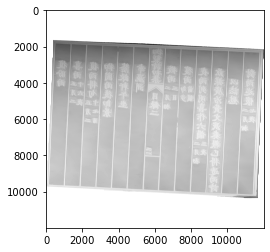

In [8]:
plt.imshow(normalized_depth_img, cmap='gray')

In [16]:
stl_r_dir_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/kho_khuon_in_r/"
stl_r_path_list = list(Path(stl_r_dir_path).glob("*.stl"))
dest_depth_dir = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/depth/"
for stl_path in tqdm(stl_r_path_list):
    stl_name = stl_path.stem
    img_inverted_matrix, normalized_depth_img = convert_pc_to_depth_map_v2(str(stl_path))
    # normalized_depth_img
    cv2.imwrite(f"{dest_depth_dir}/{stl_name}_depth.png", normalized_depth_img)
    np.save(f"{dest_depth_dir}/{stl_name}_matrix.png", img_inverted_matrix)

  0%|          | 0/16 [00:00<?, ?it/s]

{'x_max': 153.15670776367188, 'x_min': -136.14256286621094, 'y_max': 111.56896209716797, 'y_min': -98.06814575195312, 'z_min': -7.4544830322265625, 'z_max': 2.0917510986328125}
